# Frozen Lake

## Gruppe Baumgartner, Güemes, Schmid

1.   Use Frozen-lake env -> env erklären Marion
2.   Monte Carlo Constant Alpha -> Plots, Auswertung: Marion
3.   Sarsamax -> Simon -> done
3.b  Hyperparameteroptimierung ausprobieren -> Simon (wenn die Zeit reicht...)
3.c  Verschieden Versionen des Env testen (grösse, random, slippery...) -> Simon
4.   Resultate vergleichen (Q-Table und Policy)
5.   On/Off-Policy Erklärung -> Alberto
6.   Model based / Model free Erklärung -> Alberto
7.   Power Point (Google Presentation) erstellen -> Alberto bereitet vor, alle ergänzen


In [1]:
!pip install gym==0.26.0

In [2]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import random
import numpy as np
from collections import defaultdict, deque
from tqdm import trange # Processing Bar

Helper Function:

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_game_board(map_def_string, ax):
    """
    plot the board of the game given by the map_def_string on the plot ax
    and return the dimesions of the board
    """
    grid_shape = int(np.sqrt(len(map_def_string)))
    custom_map = np.array(list(map_def_string)).reshape(grid_shape, grid_shape)
    new_custom_map = np.full((grid_shape,grid_shape), 1)
    new_custom_map[custom_map == 'F'] = 1
    new_custom_map[custom_map == 'H'] = 0
    new_custom_map[custom_map == 'S'] = 3
    new_custom_map[custom_map == 'G'] = 2

    holes = np.argwhere(new_custom_map == 0 )

    print(custom_map)

    ax.cla()
    ax.imshow(new_custom_map, cmap="Set1")
    ax.grid(True)

    for hole in holes:
        ax.text(hole[1],hole[0], "Hole", ha='center', va='center')

    ax.text(0,0, "Start", ha='center', va='top')
    ax.text(grid_shape-1,grid_shape-1, "Goal", ha='center', va='center')
    return grid_shape

def plot_Q_on_game_board(Q, map_string='SFFFFHFHFFFHHFFG', name="test.png"):
    """
    Plot the Q matrix and its policy for a given frozen-lake game board
    The definition of the boars is given with the map_string.
    For example the 4x4 standart map is:
    map_string='SFFFFHFHFFFHHFFG'
    (this is also the defalt)
    """
    fig, ax = plt.subplots(figsize=(10,10))

    grid_shape = plot_game_board(map_string, ax)

    print(grid_shape)

    for key, values in enumerate(Q):
            if np.sum(values) == 0:
                # don't draw arrows for states with no q-values (end state or holes)
                continue
            posx = key // grid_shape
            posy = key % grid_shape
            action = np.argmax(values)
            # print(f'position- x={posx} y={posy}---; key={key} --;values {values}, action = {action}, value = {values[action]}')
            weight = 'normal'
            if action == 0: # Left
                dx=-1
                dy=0
                ax.text(posy, posx, "L: " + str(round(values[action], 3)), weight=weight,  ha='center', va='center')
            elif action == 1: # Down
                dx=0
                dy=1
                ax.text(posy, posx, "D: " + str(round(values[action], 3)), weight=weight,  ha='center', va='center')
            elif action == 2: # Right
                dx=1
                dy=0
                ax.text(posy, posx, "R: " + str(round(values[action], 3)), weight=weight,  ha='center', va='center')
            elif action == 3: # Up
                dx=0
                dy=-1
                ax.text(posy, posx, "U: " + str(round(values[action], 3)), weight=weight, ha='center', va='center')      
            arrow = mpatches.Arrow(y=posx,x=posy,dx=dx,dy=dy)
            ax.add_patch(arrow)
    fig.show()
    #fig.savefig("./"+name)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

def plot_values(V):
	# reshape the state-value function
	V = np.reshape(V, (4,12))
	# plot the state-value function
	fig = plt.figure(figsize=(15,5))
	ax = fig.add_subplot(111)
	im = ax.imshow(V, cmap='cool')
	for (j,i),label in np.ndenumerate(V):
	    ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
	plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
	plt.title('State-Value Function')
	plt.show()

ImportError: this version of pandas is incompatible with numpy < 1.20.3
your numpy version is 1.19.2.
Please upgrade numpy to >= 1.20.3 to use this pandas version

In [6]:
def plot_training_performance(avg_scores, n_episodes, plot_every, title, epsilons):
    # plot performance
    plt.plot(np.linspace(0,n_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores), label=f'Average Reward (Over {plot_every} Episodes)')
    if epsilons:
      plt.plot(np.linspace(0,n_episodes,len(epsilons),endpoint=False), np.asarray(epsilons), label='Epsilon')
    plt.xlabel('Episode Number')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()
    ## print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    

In [7]:
def create_frozen_lake_env(is_slippery=False, map_def_string="", random_map_size=0, map_name="4x4"):
  """
  Helper method for creating different frozen lake envs
  """
  if random_map_size > 0:
    custom_map = generate_random_map(size=random_map_size)
  elif len(map_def_string) > 0:
    grid_shape = int(np.sqrt(len(map_def_string)))
    custom_map = np.array(list(map_def_string)).reshape(grid_shape, grid_shape)
  else:
    print(f"Creating default {map_name} map, slippery: {is_slippery}")
    return gym.make('FrozenLake-v1', map_name=map_name, is_slippery=is_slippery)
  
  print(f"Creating custom map:\n{custom_map}, slippery: {is_slippery}")
  return gym.make('FrozenLake-v1', desc=custom_map, is_slippery=is_slippery)

In [8]:
# env = gym.make('FrozenLake-v1', is_slippery=False, new_step_api=True, map_name="4x4") #desc=generate_random_map(size=4))
env = create_frozen_lake_env()
#env.action_space.seed(42)
#state = env.reset(seed=42)

print(f'the current space:')
print(f'obs. space:     {env.observation_space}')
print(f'action space:   {env.action_space}')

Creating default 4x4 map, slippery: False
the current space:
obs. space:     Discrete(16)
action space:   Discrete(4)


## Monte Carlo constant $α$

1. Episdodes from Q

In [9]:
from numpy.lib.nanfunctions import nanargmax
def generate_episode(env, Q, epsilon, nActions):
  episode = []
  state = env.reset()[0]
  while True:
    probability = get_probability(Q[state, :], epsilon, nActions)
    action = np.random.choice(np.arange(nActions), p=probability) if state in Q else env.action_space.sample()

    next_state, reward, terminated, truncated, info = env.step(action)

    episode.append((state, action, reward))
    state = next_state
    if terminated or truncated: # ends when falling into the lake or reaching goal
      break
  return episode

def get_probability(Q_s, epsilon, nActions):
  policy_s = np.ones(nActions) * epsilon / nActions
  best_action = np.argmax(Q_s)
  policy_s[best_action] =1 - epsilon + (epsilon/ nActions)
  return policy_s


def update_Q_monte_carlo(env, episode, Q, alpha, gamma):
  states, actions, rewards = zip(*episode)
  discounts = np.array([gamma**i for i in range(len(rewards)+1)])

  for state_idx, state in enumerate(states):
    nr_steps_after_state = len(rewards[state_idx:])
    old_Q = Q[state][actions[state_idx]]
    Q[state][actions[state_idx]] = old_Q + alpha*(sum(rewards[state_idx:]*discounts[:nr_steps_after_state]) - old_Q)
  return Q

In [10]:
import sys

def monte_carlo_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05, plot_every=100, exp_name="Montecarlo"):
    n_states, n_actions = env.observation_space.n, env.action_space.n
    Q = np.zeros((n_states, n_actions))
    epsilon = eps_start
    t = trange(num_episodes)

    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    epsilons = deque(maxlen=num_episodes)

    for i_episode in t:

        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_episode(env, Q, epsilon, n_actions)
        Q = update_Q_monte_carlo(env, episode, Q, alpha, gamma)

        # update progress bar
        _, _, rewards = zip(*episode)
        t.set_description(f'Episode {i_episode + 1} Reward {np.max(rewards)} Epsilon {round(epsilon,3)}')
        t.refresh()
        tmp_scores.append(np.max(rewards))
        epsilons.append(epsilon)
        if (i_episode % plot_every == 0):
          avg_scores.append(np.mean(tmp_scores))
    
    plot_training_performance(avg_scores, num_episodes, plot_every, exp_name, epsilons)
    policy = dict((k , np.argmax(v)) for k, v in enumerate(Q))
    return policy, Q

Episode 100000 Reward 0.0 Epsilon 0.05: 100%|██████████| 100000/100000 [10:19<00:00, 161.42it/s]


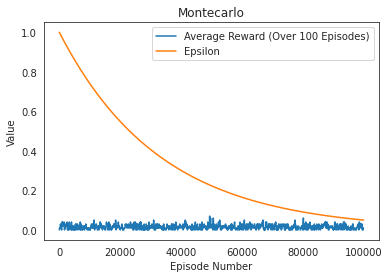

Best Average Reward over 100 Episodes:  0.07


In [10]:
policy, Q = monte_carlo_control(env, 100_000, 0.02, eps_decay=0.99997)

[['S' 'F' 'F' 'F']
 ['F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'H']
 ['H' 'F' 'F' 'G']]
4


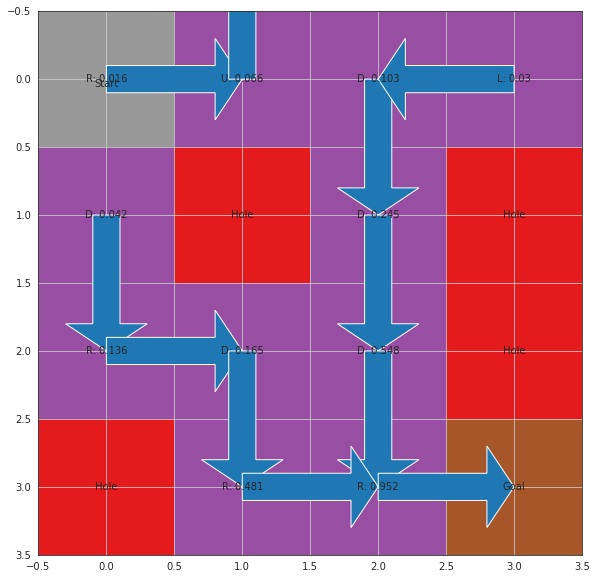

In [ ]:
plot_Q_on_game_board(Q)

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: False


Episode 100000 Reward 0.0 Epsilon 0.05: 100%|██████████| 100000/100000 [05:06<00:00, 325.87it/s]


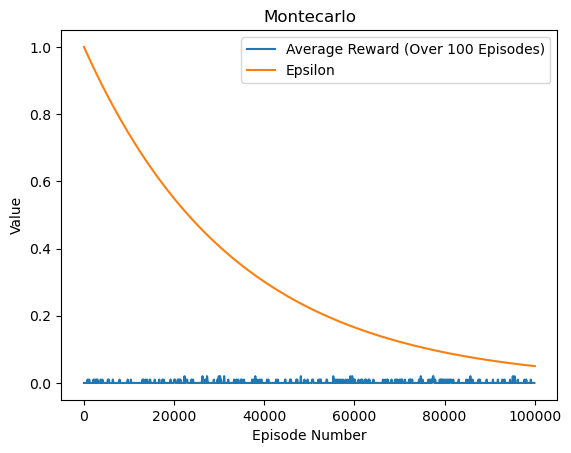

Best Average Reward over 100 Episodes:  0.02
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']]
8


C:\Users\Simu\AppData\Local\Temp\ipykernel_3172\1501171270.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


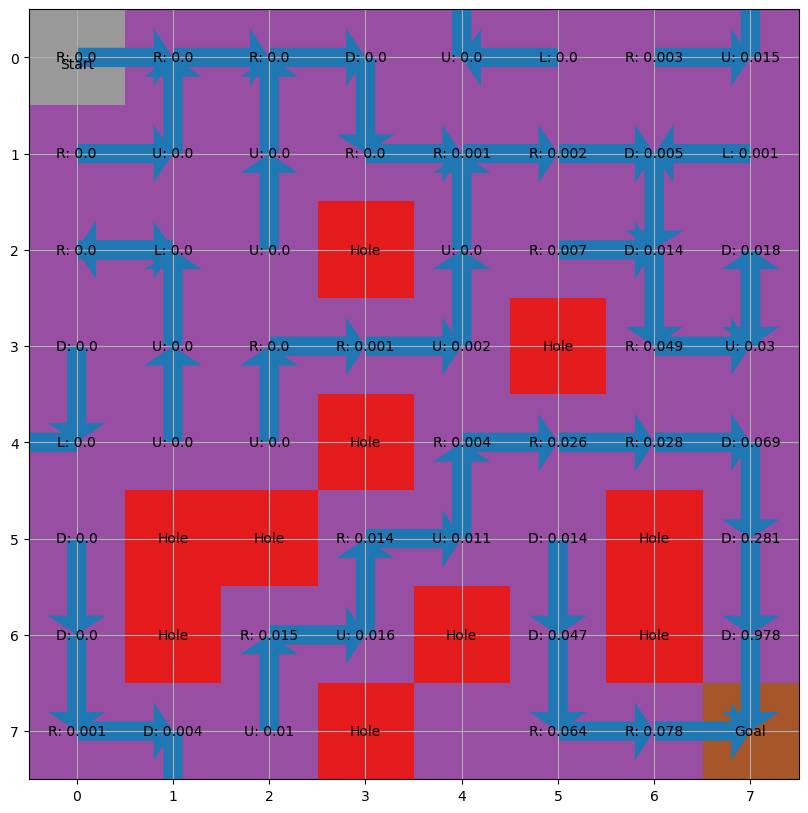

In [12]:
# Create 8x8 map
map_def = "SFFFFFFFFFFFFFFFFFFHFFFFFFFFFHFFFFFHFFFFFHHFFFHFFHFFHFHFFFFHFFFG"
env = create_frozen_lake_env(map_def_string=map_def)
policy, Q = monte_carlo_control(env, 100_000, 0.02, eps_decay=0.99997)
plot_Q_on_game_board(Q, map_string=map_def)

## SARSAMAX (Q-Learning)

$Q_{new}(s,a) = Q_{current}(s,a) + α (R + γ Q(s',a') - Q_{current}(s,a))$

- $current = Q_{current}(s,a)$
- $target = R + γ Q(s',a')$
- $Q(s',a') = Q_{next}(s,a)$

$\text{Temporal-Error} = \text{target} - \text {current}$

$lim_{t-> ∞}\text{Temporal-Error} = 0$

In [17]:
# epsilon-greedy exploration strategy
def epsilon_greedy(Q, epsilon, n_actions, s):
    """
    Q: Q Table
    epsilon: exploration parameter
    n_actions: number of actions
    s: state
    """
    # selects a random action with probability epsilon
    if np.random.random() <= epsilon:
        return np.random.randint(n_actions)
    else:
        return np.argmax(Q[s, :])

def get_target_sarsa(Q, reward, gamma, s_, a_ ):
    # value of next state -> "on policy"
    Qsa_next = Q[s_, a_] if s_ is not None else 0  
    target = reward + (gamma * Qsa_next)
    return target

def get_target_sarsamax(Q, reward, gamma, s_, a_ ):
    # "greedy" best value -> "off policy"
    Qsa_next = np.max(Q[s_]) if s_ is not None else 0
    target = reward + (gamma * Qsa_next)
    return target

def q_train(get_target_method, alpha, gamma, epsilon, n_episodes, plot_every=100, exp_name="", eps_decay=0.99999, eps_min=0.05):
    """
    get_target_method: a function which is used to get new target while updating Q-table
    alpha: learning rate
    gamma: exploration parameter
    epsilon: 
    n_episodes: number of episodes
    """
    if len(exp_name) > 0:
      print(f"===== Starting experiment: {exp_name} =====")
      print(f"[alpha:{alpha} gamma:{gamma} epsilon:{epsilon} eps_decay:{eps_decay} eps_min:{eps_min}]")
    
    n_states, n_actions = env.observation_space.n, env.action_space.n

    # initialize Q table
    Q = np.zeros((n_states, n_actions))
    t = trange(n_episodes)
    reward_array = np.zeros(n_episodes)

    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=n_episodes)   # average scores over every plot_every episodes
    epsilons = deque(maxlen=n_episodes)
    
    reached_goal_once = False
    for i in t:
      
        score = 0
        # initial state
        s = env.reset()[0]
        # initial action
        a = epsilon_greedy(Q, epsilon, n_actions, s)

        # epsilon decay
        if reached_goal_once:
          epsilon = max(epsilon*eps_decay, eps_min)

        done = False
        while not done:
            s_, reward, done, _, _ = env.step(a)
            score += reward                                 
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            # update Q table
            target = get_target_method(Q, reward, gamma, s_, a_)
            #Qsa_next = np.max(Q[s_]) if s_ is not None else 0  # value of next state
            Q[s, a] += alpha * (target - Q[s, a])
            if done:
                t.set_description(f'Episode {i + 1} Reward {reward} Epsilon {round(epsilon,3)}')
                t.refresh()
                reward_array[i] = reward
                if not reached_goal_once and reward > 0:
                  reached_goal_once = True
                tmp_scores.append(score)    # append score
                epsilons.append(epsilon)
                break
            s, a = s_, a_
        if (i % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
    env.close()

    plot_training_performance(avg_scores, n_episodes, plot_every, exp_name, epsilons)
    policy = dict((k , np.argmax(v)) for k, v in enumerate(Q))
    print(f"===== Ending experiment: {exp_name} =====\n")
    return Q, policy, reward_array, avg_scores

Creating default 4x4 map, slippery: False
===== Starting experiment: SARSAMAX Default 4x4 =====
[alpha:0.05 gamma:1.0 epsilon:1.0 eps_decay:0.99997 eps_min:0.05]


Episode 100000 Reward 1.0 Epsilon 0.05: 100%|██████████| 100000/100000 [02:23<00:00, 698.93it/s]


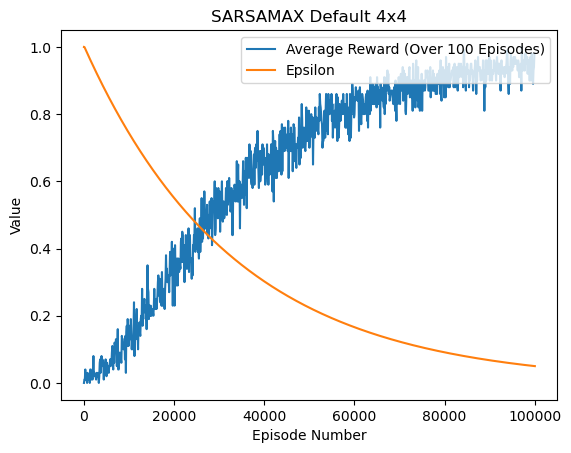

C:\Users\Simu\AppData\Local\Temp\ipykernel_3172\1501171270.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Best Average Reward over 100 Episodes:  1.0
===== Ending experiment: SARSAMAX Default 4x4 =====

[['S' 'F' 'F' 'F']
 ['F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'H']
 ['H' 'F' 'F' 'G']]
4


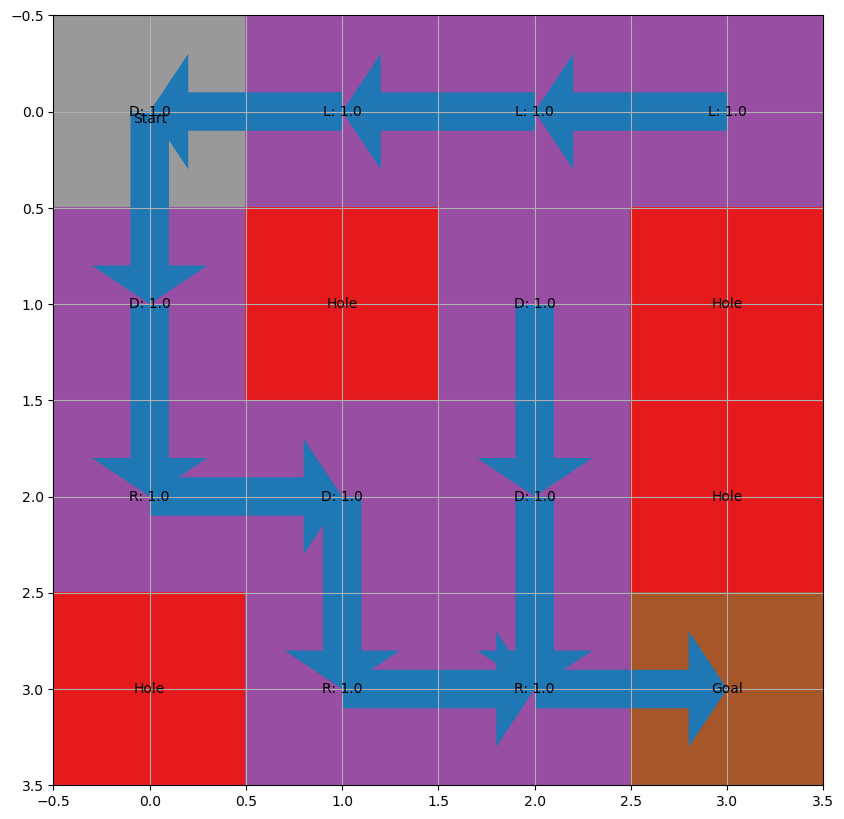

In [18]:
# 4x4 default map
env = create_frozen_lake_env()

# training experiments settings
alpha = 0.05          # learning rate
gamma = 1.0           # discount factor
epsilon = 1.0         # exploration parameter
n_episodes = 100_000  # number of training episodes

Q, policy, reward_array, avg_scores = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, eps_decay=0.99997, exp_name="SARSAMAX Default 4x4")
plot_Q_on_game_board(Q)

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: False
===== Starting experiment: SARSAMAX 8x8 =====
[alpha:0.05 gamma:1.0 epsilon:1.0 eps_decay:0.99997 eps_min:0.05]


Episode 100000 Reward 1.0 Epsilon 0.051: 100%|██████████| 100000/100000 [02:59<00:00, 555.91it/s]


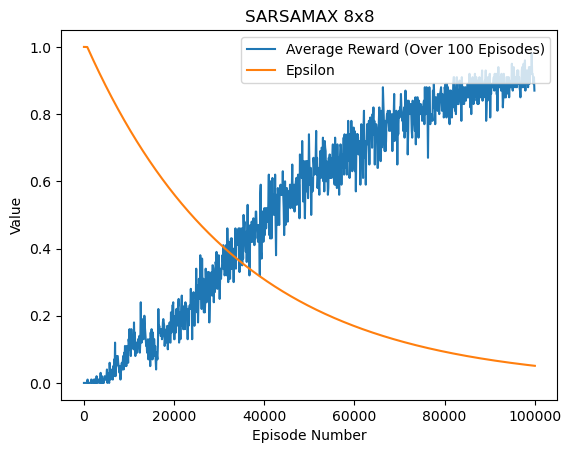

Best Average Reward over 100 Episodes:  0.98
===== Ending experiment: SARSAMAX 8x8 =====

[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']]
8


C:\Users\Simu\AppData\Local\Temp\ipykernel_3172\1501171270.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


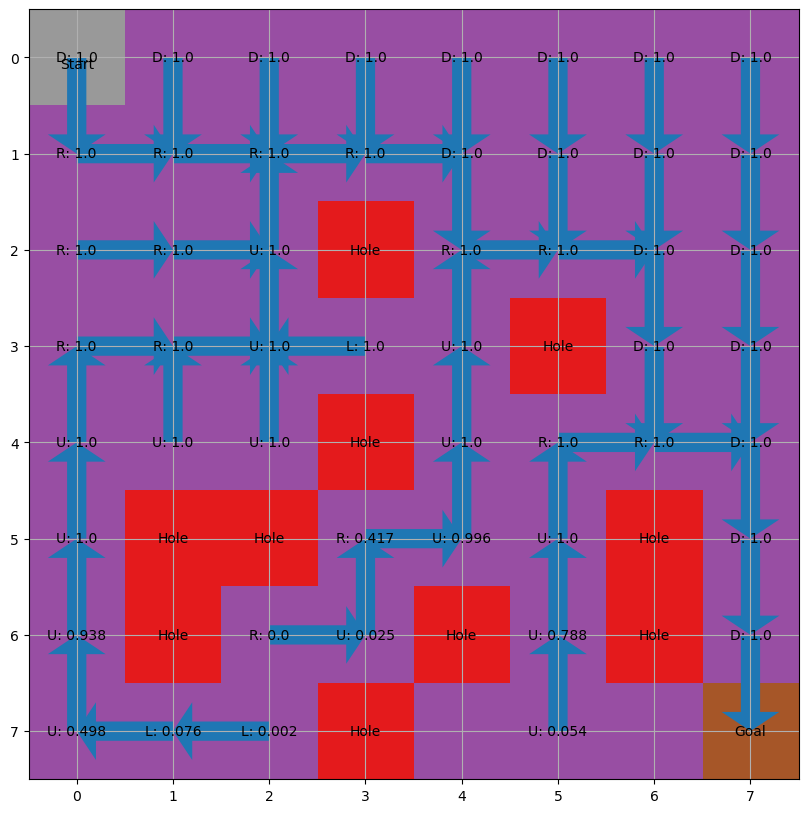

In [19]:
# Create 8x8 map
map_def = "SFFFFFFFFFFFFFFFFFFHFFFFFFFFFHFFFFFHFFFFFHHFFFHFFHFFHFHFFFFHFFFG"
env = create_frozen_lake_env(map_def_string=map_def)
Q, policy, reward_array, avg_scores = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, eps_decay=0.99997, exp_name="SARSAMAX 8x8")
plot_Q_on_game_board(Q, map_string=map_def)

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: SARSAMAX 8x8 Slippery =====
[alpha:0.05 gamma:1.0 epsilon:1.0 eps_decay:0.99997 eps_min:0.05]


Episode 100000 Reward 0.0 Epsilon 0.05: 100%|██████████| 100000/100000 [10:02<00:00, 166.02it/s]


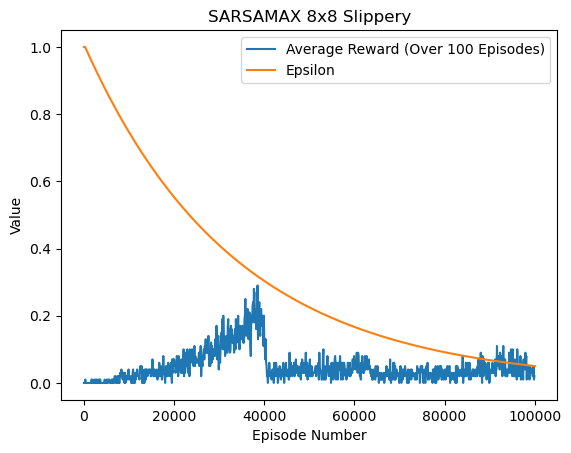

Best Average Reward over 100 Episodes:  0.29
===== Ending experiment: SARSAMAX 8x8 Slippery =====

[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']]
8


C:\Users\Simu\AppData\Local\Temp\ipykernel_3172\1501171270.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


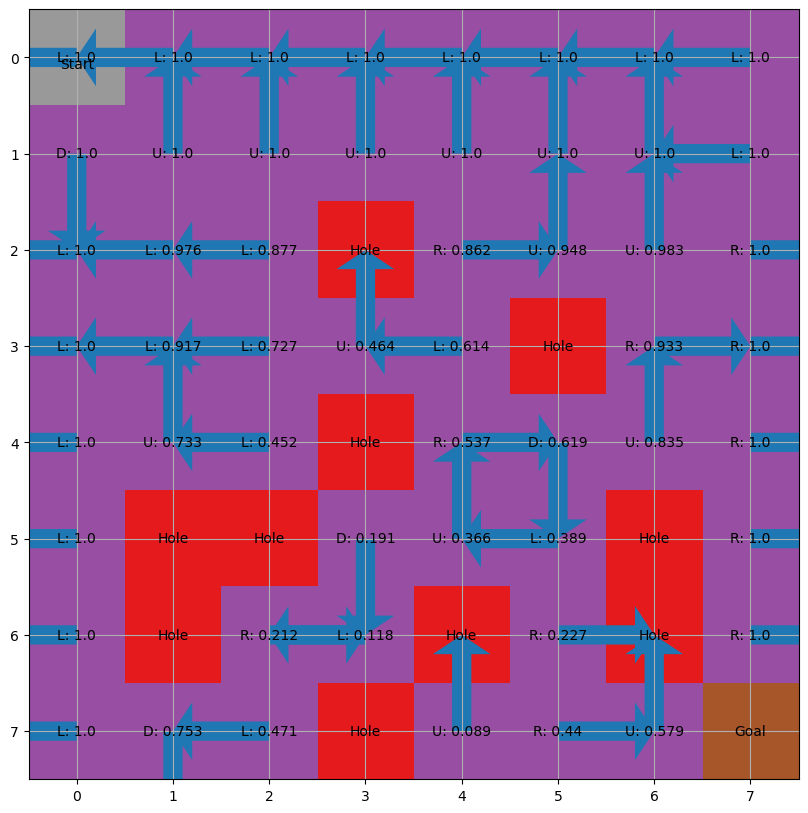

In [20]:
# Create 8x8 slippery map
map_def = "SFFFFFFFFFFFFFFFFFFHFFFFFFFFFHFFFFFHFFFFFHHFFFHFFHFFHFHFFFFHFFFG"
env = create_frozen_lake_env(map_def_string=map_def, is_slippery=True)
Q, policy, reward_array, avg_scores = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, eps_decay=0.99997, exp_name="SARSAMAX 8x8 Slippery")
plot_Q_on_game_board(Q, map_string=map_def)

Creating default 4x4 map, slippery: False
===== Starting experiment: SARSA Default 4x4 =====


Episode 149995 Reward 1.0 Epsilon 0.223: 100%|█████████▉| 149987/150000 [13:28<00:00, 223.72it/s]

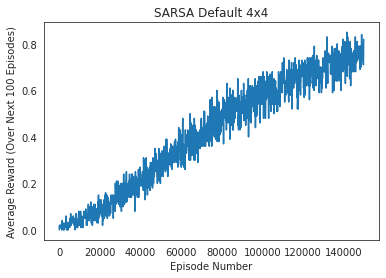

Best Average Reward over 100 Episodes:  0.85
===== Ending experiment: SARSA Default 4x4 =====

===== Starting experiment: Q-Learning Default 4x4 =====


Episode 149985 Reward 0.0 Epsilon 0.223: 100%|█████████▉| 149969/150000 [13:20<00:00, 244.27it/s]

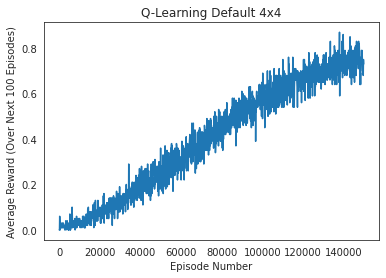

Best Average Reward over 100 Episodes:  0.87
===== Ending experiment: Q-Learning Default 4x4 =====

Creating custom map:
[['S' 'F' 'F' 'H']
 ['F' 'H' 'F' 'F']
 ['F' 'F' 'H' 'F']
 ['H' 'F' 'F' 'G']], slippery: False
===== Starting experiment: SARSA Custom 4x4 =====


Episode 150000 Reward 1.0 Epsilon 0.223: 100%|██████████| 150000/150000 [12:46<00:00, 195.76it/s]


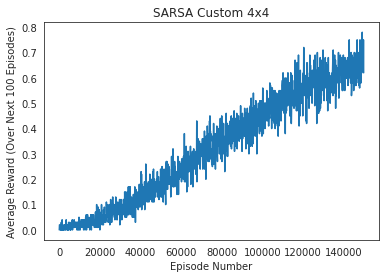

Best Average Reward over 100 Episodes:  0.78
===== Ending experiment: SARSA Custom 4x4 =====

===== Starting experiment: Q-Learning Custom 4x4 =====


Episode 149780 Reward 1.0 Epsilon 0.224: 100%|█████████▉| 149770/150000 [12:56<00:00, 248.16it/s]

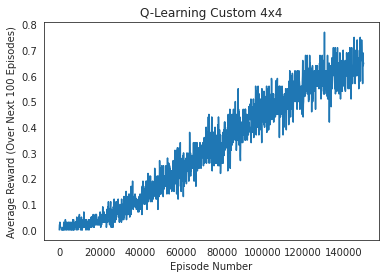

Best Average Reward over 100 Episodes:  0.77
===== Ending experiment: Q-Learning Custom 4x4 =====

Creating custom map:
[['S' 'F' 'F' 'H']
 ['F' 'H' 'F' 'F']
 ['F' 'F' 'H' 'F']
 ['H' 'F' 'F' 'G']], slippery: True
===== Starting experiment: SARSA Custom Slippery 4x4 =====


Episode 250000 Reward 0.0 Epsilon 0.09: 100%|██████████| 250000/250000 [37:29<00:00, 111.15it/s]


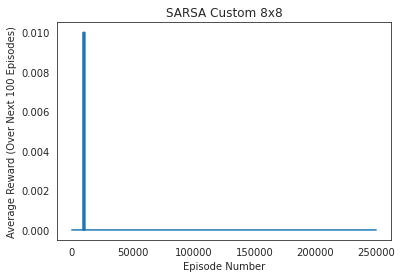

Best Average Reward over 100 Episodes:  0.01
===== Ending experiment: SARSA Custom 8x8 =====

===== Starting experiment: Q-Learning Custom 8x8 =====


Episode 250000 Reward 0.0 Epsilon 0.085: 100%|██████████| 250000/250000 [43:54<00:00, 94.90it/s]


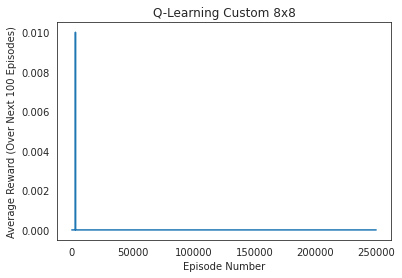

Best Average Reward over 100 Episodes:  0.01
===== Ending experiment: Q-Learning Custom 8x8 =====



In [ ]:
# training experiments settings
alpha = 0.01          # learning rate
gamma = 1.0           # discount factor
epsilon = 1.0         # exploration parameter
n_episodes = 150_000  # number of training episodes

# TODO Simon: test hyperparam optimiziation on different maps

# 4x4 Default
env = create_frozen_lake_env()
Q, reward_array = q_train(get_target_sarsa, alpha, gamma, epsilon, n_episodes, exp_name="SARSA Default 4x4")
Q, reward_array = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, exp_name="Q-Learning Default 4x4")

# 4x4 Custom
env = create_frozen_lake_env(map_def_string="SFFHFHFFFFHFHFFG")
Q, reward_array = q_train(get_target_sarsa, alpha, gamma, epsilon, n_episodes, exp_name="SARSA Custom 4x4")
Q, reward_array = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, exp_name="Q-Learning Custom 4x4")

# 4x4 Custom Slippery
env = create_frozen_lake_env(map_def_string="SFFHFHFFFFHFHFFG", is_slippery=True)
Q, reward_array = q_train(get_target_sarsa, alpha, gamma, epsilon, n_episodes, exp_name="SARSA Custom Slippery 4x4")
Q, reward_array = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, exp_name="Q-Learning Custom Slippery 4x4")

# 8x8
env = create_frozen_lake_env(map_def_string="SFFFHFFFFFFHFHFFFFHFFFFFHFFFFFHFFFFFFFFHFFFFHFFHFFFFFHFFFFFHFFFG")
n_episodes = 250_000
gamma = 0.5
Q, reward_array = q_train(get_target_sarsa, alpha, gamma, epsilon, n_episodes, exp_name="SARSA Custom 8x8")
Q, reward_array = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, exp_name="Q-Learning Custom 8x8")

In [ ]:
!pip install optuna

[I 2022-12-13 00:17:20,931] A new study created in memory with name: no-name-9d356361-0ab1-4b41-978a-df08c0bd3c64


Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.16139938524970027 gamma:0.6178111553157329 epsilon:0.9032615024682606 eps_decay:0.9999887065626262 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.518: 100%|██████████| 50000/50000 [01:55<00:00, 434.04it/s]


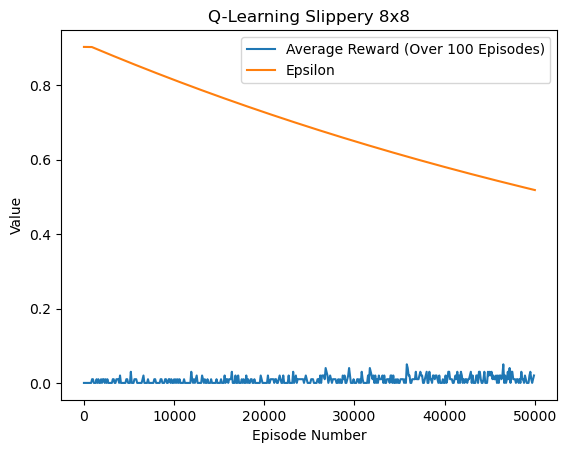

[I 2022-12-13 00:19:16,301] Trial 0 finished with value: 0.05 and parameters: {'alpha': 0.16139938524970027, 'gamma': 0.6178111553157329, 'epsilon': 0.9032615024682606, 'eps_decay': 0.9999887065626262}. Best is trial 0 with value: 0.05.


Best Average Reward over 100 Episodes:  0.05
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.02650933462569247 gamma:0.5009378135800356 epsilon:0.8250418189108977 eps_decay:0.9999197802595903 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [01:56<00:00, 430.17it/s] 


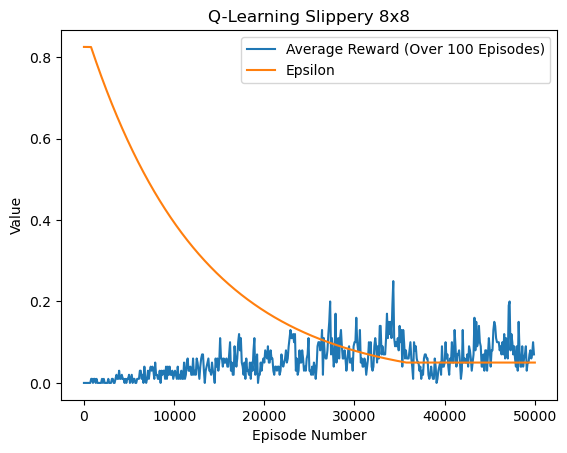

[I 2022-12-13 00:21:12,700] Trial 1 finished with value: 0.25 and parameters: {'alpha': 0.02650933462569247, 'gamma': 0.5009378135800356, 'epsilon': 0.8250418189108977, 'eps_decay': 0.9999197802595903}. Best is trial 1 with value: 0.25.


Best Average Reward over 100 Episodes:  0.25
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.08339876589749393 gamma:0.947351547100041 epsilon:0.9006652027548723 eps_decay:0.9999896345580279 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.539: 100%|██████████| 50000/50000 [02:13<00:00, 375.84it/s]


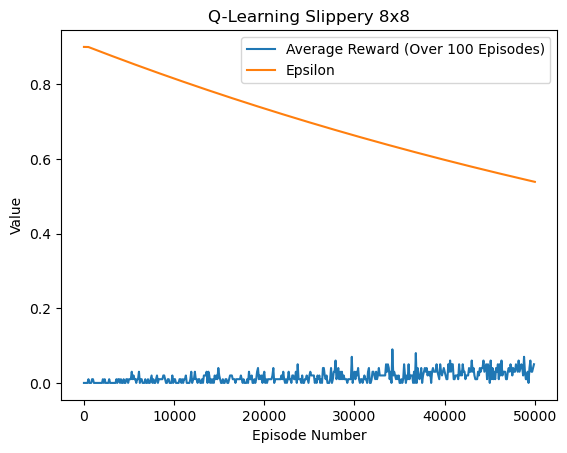

[I 2022-12-13 00:23:25,919] Trial 2 finished with value: 0.09 and parameters: {'alpha': 0.08339876589749393, 'gamma': 0.947351547100041, 'epsilon': 0.9006652027548723, 'eps_decay': 0.9999896345580279}. Best is trial 1 with value: 0.25.


Best Average Reward over 100 Episodes:  0.09
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.09315260073889285 gamma:0.6494459575592989 epsilon:0.8224964819164922 eps_decay:0.9999730589742858 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.222: 100%|██████████| 50000/50000 [02:00<00:00, 414.43it/s]


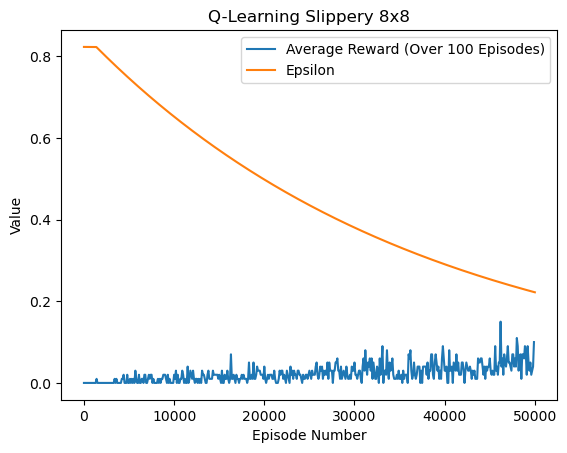

[I 2022-12-13 00:25:26,735] Trial 3 finished with value: 0.15 and parameters: {'alpha': 0.09315260073889285, 'gamma': 0.6494459575592989, 'epsilon': 0.8224964819164922, 'eps_decay': 0.9999730589742858}. Best is trial 1 with value: 0.25.


Best Average Reward over 100 Episodes:  0.15
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.061526686168899336 gamma:0.6276301277608614 epsilon:0.9505614889174783 eps_decay:0.9999517349322765 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.091: 100%|██████████| 50000/50000 [02:00<00:00, 413.74it/s]


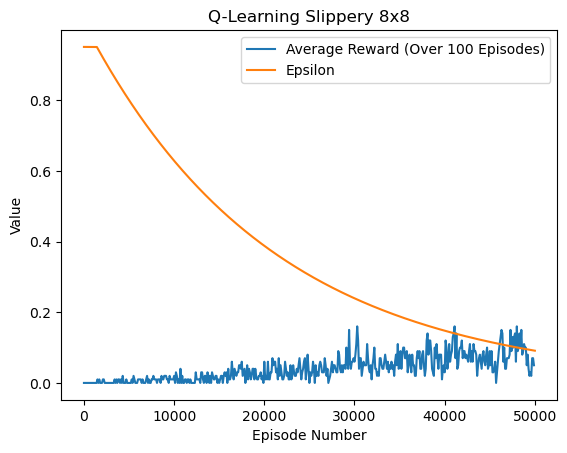

[I 2022-12-13 00:27:27,792] Trial 4 finished with value: 0.16 and parameters: {'alpha': 0.061526686168899336, 'gamma': 0.6276301277608614, 'epsilon': 0.9505614889174783, 'eps_decay': 0.9999517349322765}. Best is trial 1 with value: 0.25.


Best Average Reward over 100 Episodes:  0.16
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.010446646608272697 gamma:0.6479881739777444 epsilon:0.8626110479268801 eps_decay:0.9999178151999115 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:07<00:00, 392.67it/s] 


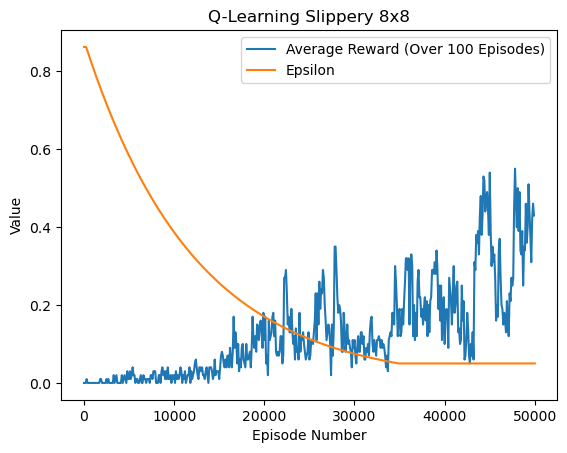

[I 2022-12-13 00:29:35,309] Trial 5 finished with value: 0.55 and parameters: {'alpha': 0.010446646608272697, 'gamma': 0.6479881739777444, 'epsilon': 0.8626110479268801, 'eps_decay': 0.9999178151999115}. Best is trial 5 with value: 0.55.


Best Average Reward over 100 Episodes:  0.55
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.049066105212417055 gamma:0.7492335884332968 epsilon:0.9316226727379151 eps_decay:0.9999151532363038 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [05:14<00:00, 159.10it/s] 


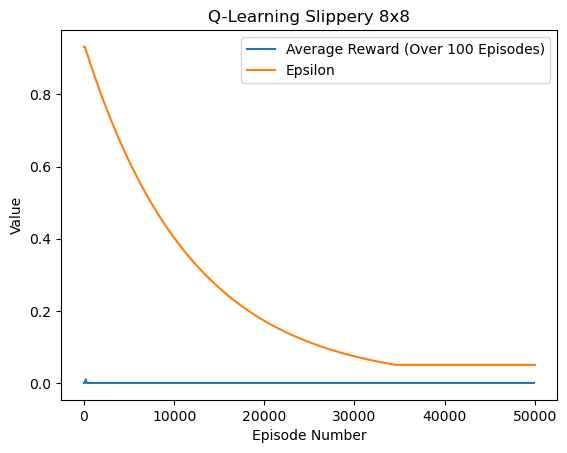

[I 2022-12-13 00:34:49,744] Trial 6 finished with value: 0.01 and parameters: {'alpha': 0.049066105212417055, 'gamma': 0.7492335884332968, 'epsilon': 0.9316226727379151, 'eps_decay': 0.9999151532363038}. Best is trial 5 with value: 0.55.


Best Average Reward over 100 Episodes:  0.01
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.010960579942619574 gamma:0.9674807686370586 epsilon:0.9543939947510499 eps_decay:0.9999582237231873 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.12: 100%|██████████| 50000/50000 [02:30<00:00, 331.79it/s] 


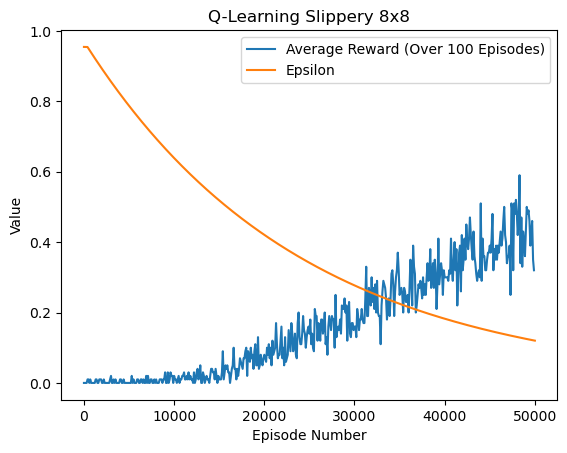

[I 2022-12-13 00:37:20,626] Trial 7 finished with value: 0.59 and parameters: {'alpha': 0.010960579942619574, 'gamma': 0.9674807686370586, 'epsilon': 0.9543939947510499, 'eps_decay': 0.9999582237231873}. Best is trial 7 with value: 0.59.


Best Average Reward over 100 Episodes:  0.59
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.33472627053273435 gamma:0.5994745023946249 epsilon:0.9119778735661745 eps_decay:0.9999052463875658 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [01:58<00:00, 421.61it/s] 


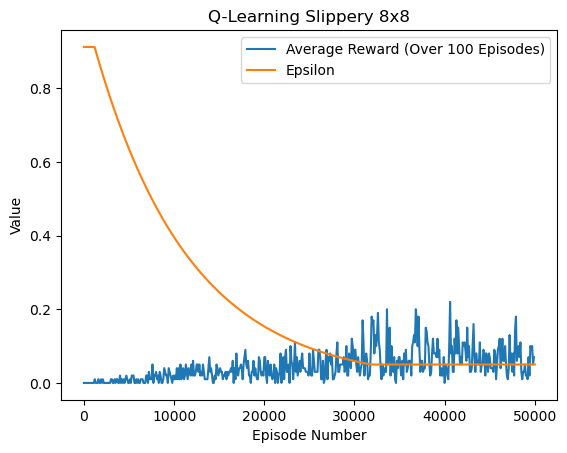

[I 2022-12-13 00:39:19,370] Trial 8 finished with value: 0.22 and parameters: {'alpha': 0.33472627053273435, 'gamma': 0.5994745023946249, 'epsilon': 0.9119778735661745, 'eps_decay': 0.9999052463875658}. Best is trial 7 with value: 0.59.


Best Average Reward over 100 Episodes:  0.22
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.013895368863586676 gamma:0.5314602130457826 epsilon:0.8454784046541586 eps_decay:0.9999610731030397 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.134: 100%|██████████| 50000/50000 [01:55<00:00, 434.01it/s]


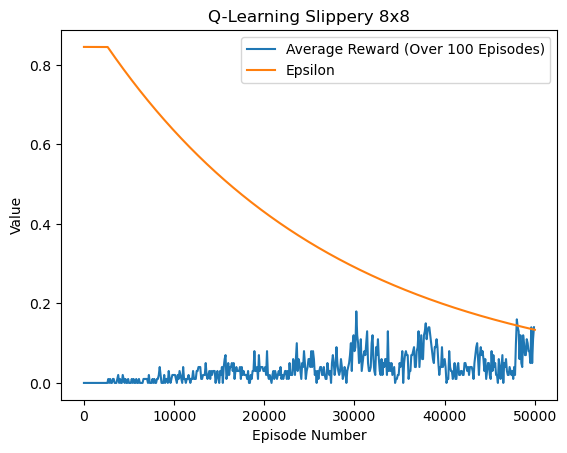

[I 2022-12-13 00:41:14,743] Trial 9 finished with value: 0.18 and parameters: {'alpha': 0.013895368863586676, 'gamma': 0.5314602130457826, 'epsilon': 0.8454784046541586, 'eps_decay': 0.9999610731030397}. Best is trial 7 with value: 0.59.


Best Average Reward over 100 Episodes:  0.18
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.030041472151392103 gamma:0.9503389410917502 epsilon:0.9785628623821673 eps_decay:0.9999412854510462 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.052: 100%|██████████| 50000/50000 [02:39<00:00, 314.06it/s]


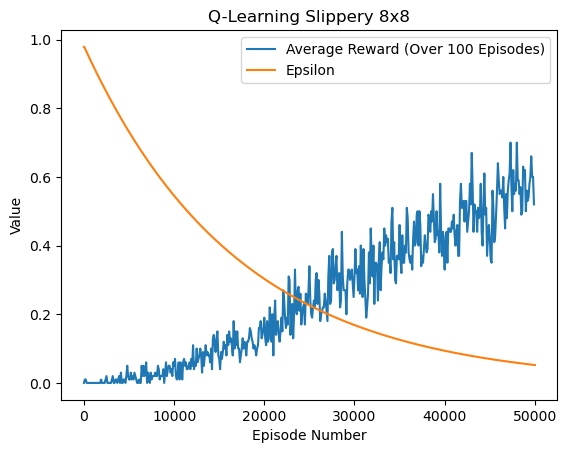

[I 2022-12-13 00:43:54,119] Trial 10 finished with value: 0.7 and parameters: {'alpha': 0.030041472151392103, 'gamma': 0.9503389410917502, 'epsilon': 0.9785628623821673, 'eps_decay': 0.9999412854510462}. Best is trial 10 with value: 0.7.


Best Average Reward over 100 Episodes:  0.7
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.025040984241827876 gamma:0.9916317051621053 epsilon:0.9964557307744422 eps_decay:0.9999370309549167 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:59<00:00, 278.14it/s] 


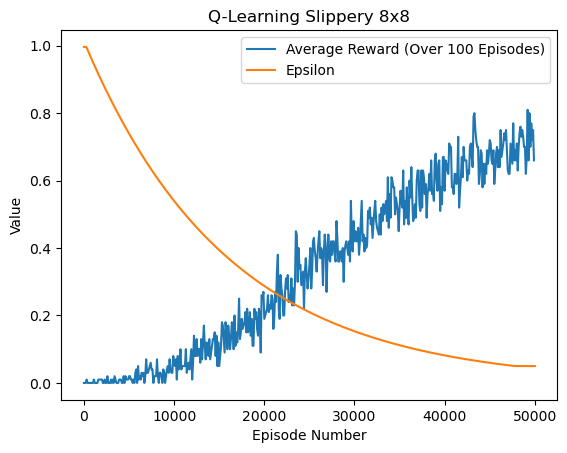

[I 2022-12-13 00:46:54,055] Trial 11 finished with value: 0.81 and parameters: {'alpha': 0.025040984241827876, 'gamma': 0.9916317051621053, 'epsilon': 0.9964557307744422, 'eps_decay': 0.9999370309549167}. Best is trial 11 with value: 0.81.


Best Average Reward over 100 Episodes:  0.81
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.028589963046889252 gamma:0.8360657783045045 epsilon:0.996253428215145 eps_decay:0.999935722856737 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:26<00:00, 341.92it/s] 


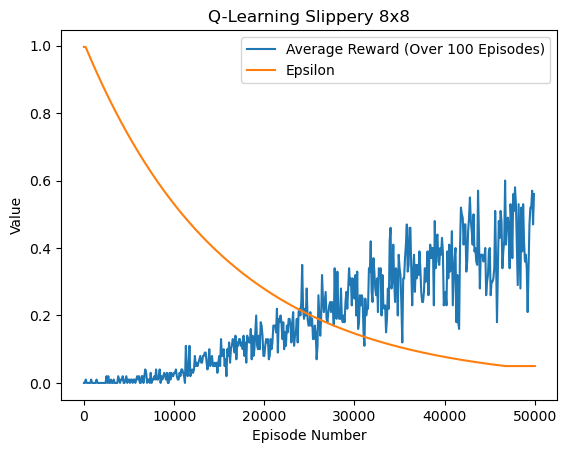

[I 2022-12-13 00:49:20,474] Trial 12 finished with value: 0.6 and parameters: {'alpha': 0.028589963046889252, 'gamma': 0.8360657783045045, 'epsilon': 0.996253428215145, 'eps_decay': 0.999935722856737}. Best is trial 11 with value: 0.81.


Best Average Reward over 100 Episodes:  0.6
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.026176505790191484 gamma:0.8601548917059588 epsilon:0.999592942897927 eps_decay:0.9999355847115499 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:29<00:00, 335.35it/s] 


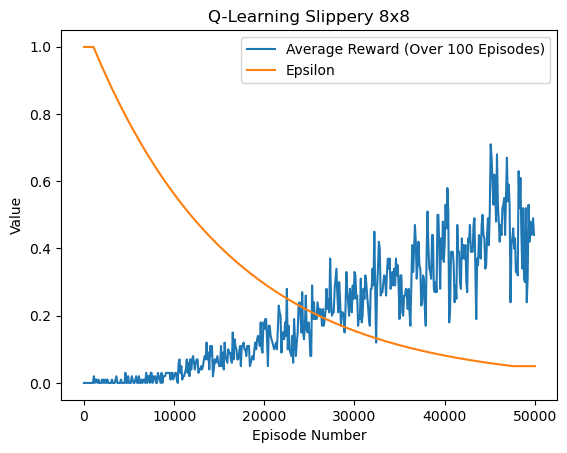

[I 2022-12-13 00:51:49,767] Trial 13 finished with value: 0.71 and parameters: {'alpha': 0.026176505790191484, 'gamma': 0.8601548917059588, 'epsilon': 0.999592942897927, 'eps_decay': 0.9999355847115499}. Best is trial 11 with value: 0.81.


Best Average Reward over 100 Episodes:  0.71
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.018523664321075564 gamma:0.8398397863601701 epsilon:0.99921338814814 eps_decay:0.9999321866219544 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:25<00:00, 344.53it/s] 


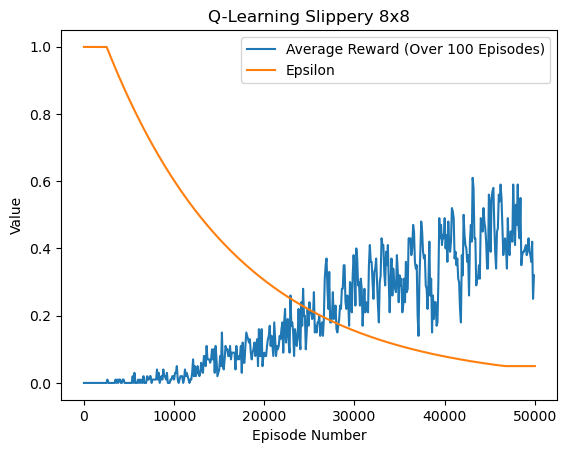

[I 2022-12-13 00:54:15,079] Trial 14 finished with value: 0.61 and parameters: {'alpha': 0.018523664321075564, 'gamma': 0.8398397863601701, 'epsilon': 0.99921338814814, 'eps_decay': 0.9999321866219544}. Best is trial 11 with value: 0.81.


Best Average Reward over 100 Episodes:  0.61
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.03626169241724628 gamma:0.8484670973171802 epsilon:0.9643294800149311 eps_decay:0.9999295042682665 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:26<00:00, 340.30it/s] 


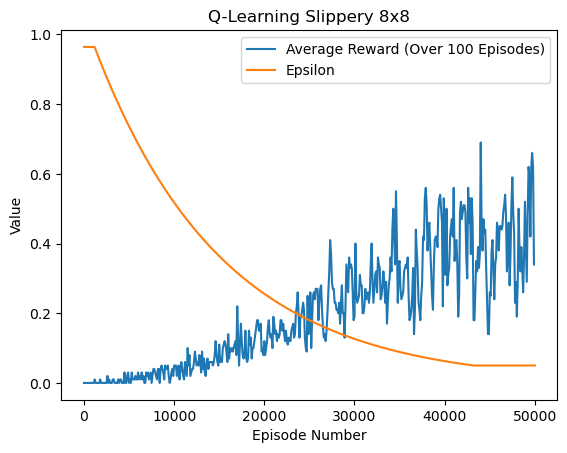

[I 2022-12-13 00:56:42,203] Trial 15 finished with value: 0.69 and parameters: {'alpha': 0.03626169241724628, 'gamma': 0.8484670973171802, 'epsilon': 0.9643294800149311, 'eps_decay': 0.9999295042682665}. Best is trial 11 with value: 0.81.


Best Average Reward over 100 Episodes:  0.69
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.01766952571681405 gamma:0.7777432619434788 epsilon:0.8724713967392812 eps_decay:0.9999471527354434 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.062: 100%|██████████| 50000/50000 [02:17<00:00, 364.58it/s]


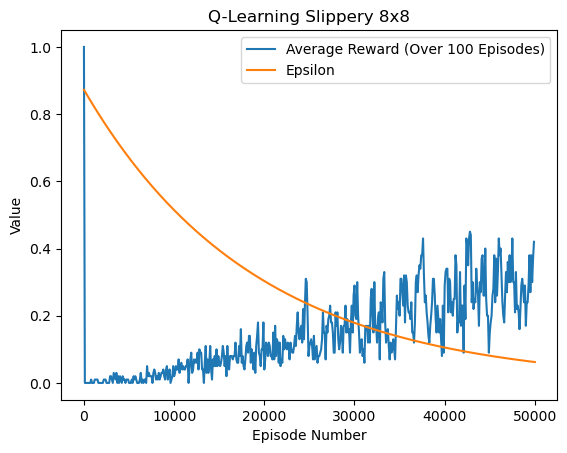

[I 2022-12-13 00:58:59,525] Trial 16 finished with value: 1.0 and parameters: {'alpha': 0.01766952571681405, 'gamma': 0.7777432619434788, 'epsilon': 0.8724713967392812, 'eps_decay': 0.9999471527354434}. Best is trial 16 with value: 1.0.


Best Average Reward over 100 Episodes:  1.0
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.01901940514006707 gamma:0.741783472414186 epsilon:0.8790013714670708 eps_decay:0.9999498109363513 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.072: 100%|██████████| 50000/50000 [02:14<00:00, 371.67it/s]


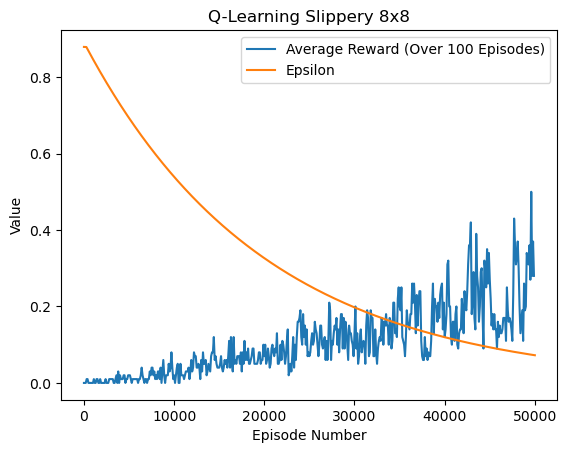

[I 2022-12-13 01:01:14,211] Trial 17 finished with value: 0.5 and parameters: {'alpha': 0.01901940514006707, 'gamma': 0.741783472414186, 'epsilon': 0.8790013714670708, 'eps_decay': 0.9999498109363513}. Best is trial 16 with value: 1.0.


Best Average Reward over 100 Episodes:  0.5
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.15538744501307175 gamma:0.7641466001124502 epsilon:0.8012785642901246 eps_decay:0.9999679733182031 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.166: 100%|██████████| 50000/50000 [02:05<00:00, 397.26it/s]


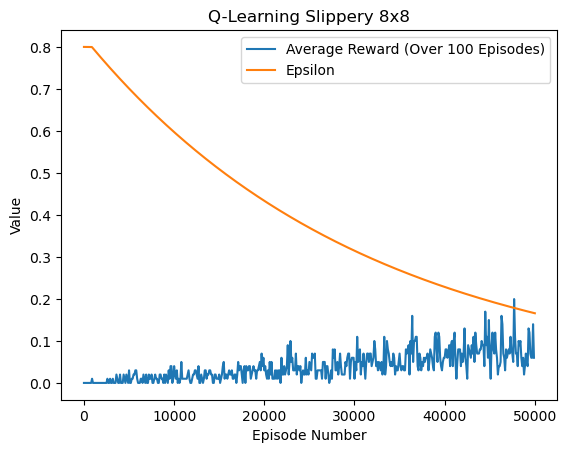

[I 2022-12-13 01:03:20,278] Trial 18 finished with value: 0.2 and parameters: {'alpha': 0.15538744501307175, 'gamma': 0.7641466001124502, 'epsilon': 0.8012785642901246, 'eps_decay': 0.9999679733182031}. Best is trial 16 with value: 1.0.


Best Average Reward over 100 Episodes:  0.2
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.01631616680184016 gamma:0.9958196556629112 epsilon:0.8748977239975184 eps_decay:0.9999434880235399 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.052: 100%|██████████| 50000/50000 [03:10<00:00, 262.53it/s]


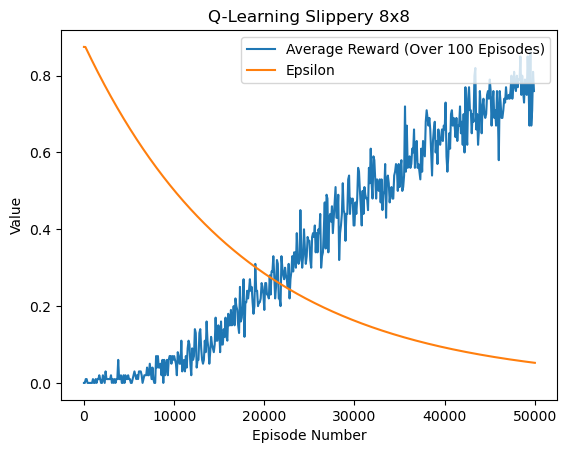

[I 2022-12-13 01:06:30,900] Trial 19 finished with value: 0.86 and parameters: {'alpha': 0.01631616680184016, 'gamma': 0.9958196556629112, 'epsilon': 0.8748977239975184, 'eps_decay': 0.9999434880235399}. Best is trial 16 with value: 1.0.


Best Average Reward over 100 Episodes:  0.86
===== Ending experiment: Q-Learning Slippery 8x8 =====

Accuracy: 1.0
Best hyperparameters: {'alpha': 0.01766952571681405, 'gamma': 0.7777432619434788, 'epsilon': 0.8724713967392812, 'eps_decay': 0.9999471527354434}


In [26]:
import optuna

map_def = "SFFFFFFFFFFFFFFFFFFHFFFFFFFFFHFFFFFHFFFFFHHFFFHFFHFFHFHFFFFHFFFG"

def objective(trial):
    # training experiments settings
    alpha = 0.05          # learning rate
    gamma = 1.0           # discount factor
    epsilon = 1.0         # exploration parameter
    n_episodes = 50_000  # number of training episodes

    # 8x8 Slippery
    env = create_frozen_lake_env(map_def_string=map_def, is_slippery=True)

    alpha = trial.suggest_float('alpha', 0.01, 0.5, log=True) # learning rate
    gamma = trial.suggest_float('gamma', 0.5, 1.0, log=True)    # starting discount factor
    epsilon = trial.suggest_float('epsilon', 0.8, 1.0, log=True)  # exploration parameter
    eps_decay = trial.suggest_float('eps_decay', 0.9999, 0.99999, log=True)  # decay rate of epsilon

    #Q, policy, reward_array, avg_scores = q_train(get_target_sarsa, alpha, gamma, epsilon, n_episodes, exp_name="SARSA Default 4x4")
    Q, policy, reward_array, avg_scores = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, exp_name="Q-Learning Slippery 8x8", eps_decay=eps_decay)
    
    return np.max(avg_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: SARSAMAX 8x8 Slippery - Best =====
[alpha:0.016 gamma:0.9958 epsilon:0.875 eps_decay:0.999943 eps_min:0.05]


Episode 100000 Reward 0.0 Epsilon 0.05: 100%|██████████| 100000/100000 [07:03<00:00, 236.16it/s]


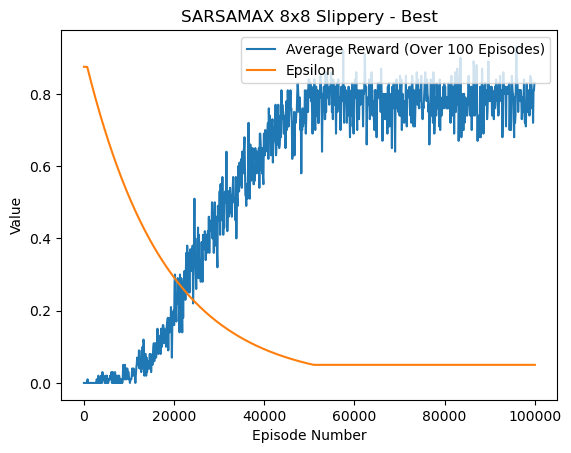

Best Average Reward over 100 Episodes:  0.93
===== Ending experiment: SARSAMAX 8x8 Slippery - Best =====

[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']]
8


C:\Users\Simu\AppData\Local\Temp\ipykernel_3172\1501171270.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


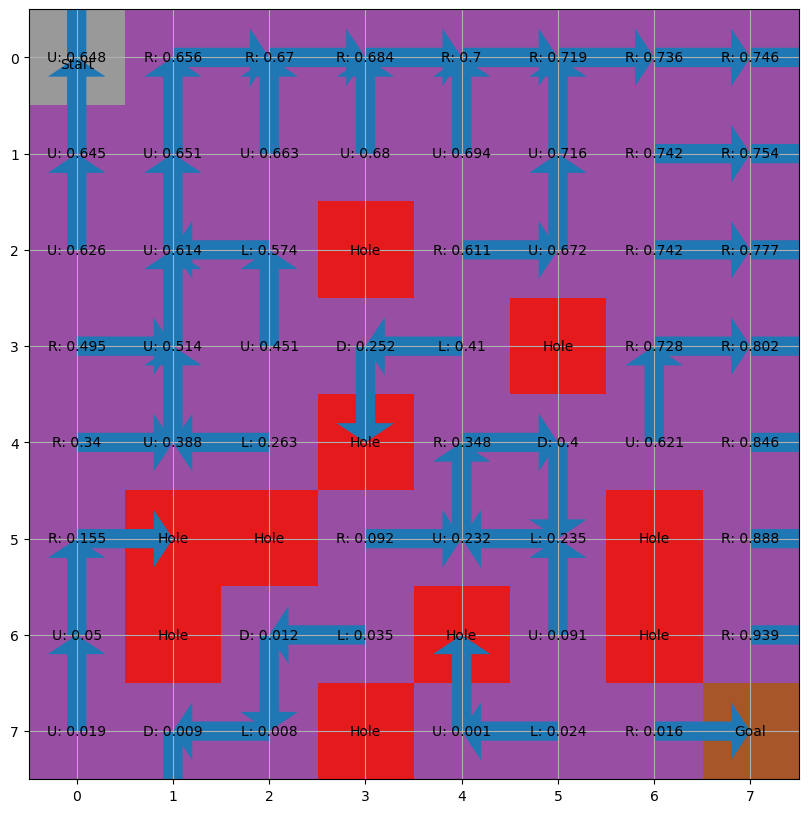

In [27]:
# Best result of optimization, stretched to 100_000 episodes 
# Create 8x8 slippery map
map_def = "SFFFFFFFFFFFFFFFFFFHFFFFFFFFFHFFFFFHFFFFFHHFFFHFFHFFHFHFFFFHFFFG"
env = create_frozen_lake_env(map_def_string=map_def, is_slippery=True)
n_episodes = 100_000
alpha = 0.016
gamma = 0.9958
epsilon = 0.875
eps_decay = 0.999943
Q, policy, reward_array, avg_scores = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, eps_decay=eps_decay, exp_name="SARSAMAX 8x8 Slippery - Best")
plot_Q_on_game_board(Q, map_string=map_def)

This is the old implementation of q-learning, it's just here for reference at the moment -> TODO Simon: remove after we are done

Episode 50000/50000

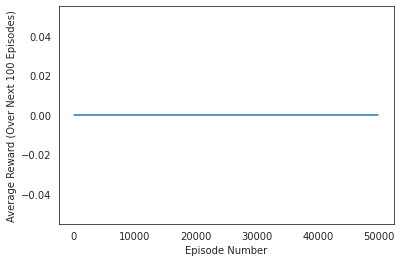

Best Average Reward over 100 Episodes:  0.0
policy: {0: 0, 1: 0, 4: 0, 8: 0, 12: 0, 5: 0, 9: 0, 2: 0, 10: 0, 13: 0, 3: 0, 6: 0, 14: 0, 11: 0}


In [ ]:
policy, Q = q_learning(env, 50000, 0.2)

print(f'policy: {policy}')

# print(f'Q-matix: {Q}')

In [ ]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
  current = Q[state][action]
  Qsa_next = np.max(Q[next_state]) if next_state is not None else 0
  target = reward + (gamma * Qsa_next)
  new_value = current + (alpha * (target - current))
  if reward > 0:
    print(f"alpha {alpha}, gamma {gamma}, next_state {next_state}, reward {reward}, new_value {new_value}")
  return new_value

def epsilon_greedy(Q, state, eps):
  if random.random() > eps: # select greedy action with probability epsilon
    return np.argmax(Q[state])
  else:                     # otherwise, select an action randomly
    return env.action_space.sample()

def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
  nA = env.action_space.n
  Q = defaultdict(lambda: np.zeros(nA))

  # monitor performance
  tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
  avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
  for i_episode in range(1, num_episodes+1):
    if i_episode % 100 == 0:
      print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
      sys.stdout.flush()
    score = 0
    state = env.reset()      
    reward = 0                          
    eps = max(1.0 / i_episode, 0.1)

    while True:
      action = epsilon_greedy(Q, state, eps)         
      next_state, reward, terminated, truncated, info = env.step(action)  
      score += reward
      #print(score)                                   
      Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state)        
      state = next_state                                 
      if terminated or truncated:
        tmp_scores.append(score)                       
        break
    if (i_episode % plot_every == 0):
      avg_scores.append(np.mean(tmp_scores))

  # plot performance
  plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
  plt.xlabel('Episode Number')
  plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
  plt.show()
  # print best 100-episode performance
  print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
  policy = dict((k,np.argmax(v)) for k, v in Q.items())
  return policy, Q